In [ ]:
!pip uninstall -y numpy
!pip install numpy==1.26.4 --upgrade --force-reinstall --quiet

In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
import numpy as np
print(np.__version__)

1.26.4


In [ ]:
#Install dependencies
!pip install pennylane pennylane-lightning

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset

import math
import re
import pandas as pd
import numpy as np
import time
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import pennylane as qml

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

In [ ]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Data Loading and Preprocessing**

In [ ]:
with open("/content/drive/MyDrive/QML-Research/Data/sentiment labelled sentences/amazon_cells_labelled.txt", "r") as f:
    lines = f.readlines()

sentences = [line.split("\t")[0] for line in lines]
labels = [int(line.split("\t")[1]) for line in lines]

In [ ]:
def stopword_tokenize(sequence):
  sequence = re.sub(r"[^\w\s]", "", sequence.lower())
  tokens = sequence.split()
  return [word for word in tokens if word not in stop_words]

cleaned_sents = [stopword_tokenize(sentence) for sentence in sentences]

# **EDA**

Sentence Lengths:
min = 1
max = 17
mean = 5.36
95th percentile = 12.0



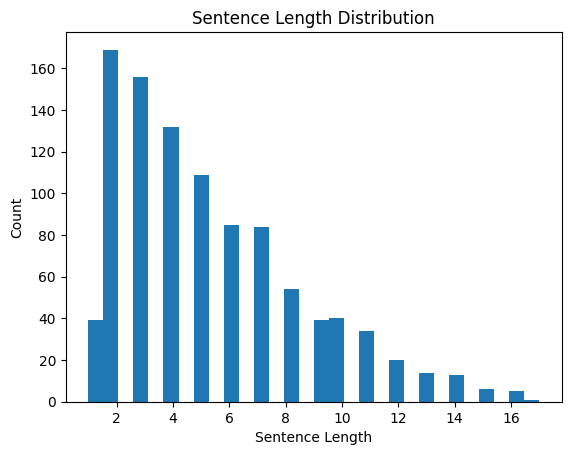

In [ ]:
lengths = [len(s) for s in cleaned_sents]
print(f"Sentence Lengths:\nmin = {np.min(lengths)}\nmax = {np.max(lengths)}\nmean = {np.mean(lengths):.2f}\n95th percentile = {np.percentile(lengths, 95)}")
print()
plt.hist(lengths, bins = 30)
plt.title("Sentence Length Distribution")
plt.xlabel("Sentence Length")
plt.ylabel("Count")
plt.show()

# **Padding and Truncation**

In [ ]:
max_len = 10
for i in range(len(cleaned_sents)):
  if (len(cleaned_sents[i]) < max_len):
    cleaned_sents[i] += ["<PAD>"] * (max_len - len(cleaned_sents[i]))
  else:
    cleaned_sents[i] = cleaned_sents[i][:max_len]

# **BOW Approach**

In [ ]:
vectorizer = CountVectorizer(binary=True)
X = vectorizer.fit_transform(sentences).toarray()
X = torch.tensor(X).float()
y = torch.tensor(labels).float()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Word Embeddings approach**

In [ ]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
cleaned_sents_str = [" ".join(tokens) for tokens in cleaned_sents]

X_embed = embedding_model.encode(cleaned_sents_str)
X_embed = torch.tensor(X_embed).float()
y_embed = torch.tensor(labels).float()

In [ ]:
df = pd.DataFrame({
    "original_sentence": sentences,
    "cleaned_sentence": cleaned_sents_str,
    "label": labels
})

df.to_csv("preprocessed_dataset.csv", index=False)

# **Manual GloVe Embedding**

In [ ]:
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

In [ ]:
def sentence_to_vec(sentence, embeddings, dim):
    vectors = []
    for word in sentence:
        if word in embeddings:
            vectors.append(embeddings[word])
        else:
            vectors.append(np.zeros(dim))
    return vectors

In [ ]:
def embed_sentences(cleaned_sents, embeddings, dim=5):
    return np.array([sentence_to_vec(tokens, embeddings, dim) for tokens in cleaned_sents])

In [ ]:
glove_path = '/content/drive/MyDrive/QML-Research/Data/glove.6B.100d.txt'
glove = load_glove_embeddings(glove_path)

# **PCA**

In [ ]:
all_words = list(glove.keys())
all_vectors = np.array([glove[word] for word in all_words])
pca = PCA(n_components=5, random_state=42)
reduced_vectors = pca.fit_transform(all_vectors)
reduced_embeddings = {word: reduced_vectors[i] for i, word in enumerate(all_words)}

# **Word Encoding**

In [ ]:
X_embed_np = embed_sentences(cleaned_sents, reduced_embeddings, dim=5)
X_embed = torch.tensor(X_embed_np).float()
y_embed = torch.tensor(labels).float()

In [ ]:
X_embed[0]

tensor([[-5.1434,  0.1227, -0.1000,  0.8167, -0.0721],
        [-2.6515, -0.7081, -0.2830,  0.2847, -0.3688],
        [-5.1575, -0.3596, -0.3783, -1.3313, -1.4052],
        [-3.2855, -0.0787, -0.3916,  0.5108, -0.7572],
        [-4.6692,  0.0774, -0.2075,  0.0456, -1.0315],
        [-1.6637, -0.9967, -0.0100, -0.4333, -0.3576],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])

# **DataLoader**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_embed, y_embed, test_size=0.2, random_state=42)

In [ ]:
class AmazonDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
small_train_dataset = Subset(AmazonDataset(X_train, y_train), list(range(100)))
train_loader_small = DataLoader(small_train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(AmazonDataset(X_test, y_test), batch_size=1)

In [ ]:
len(test_loader)

200

In [ ]:
xbtemp, ybtemp = next(iter(train_loader_small))
xbtemp

tensor([[[-4.1231, -0.1973, -0.0499,  0.4890, -0.1557],
         [-3.6860,  0.3870, -0.6795,  0.8616, -0.5788],
         [-2.5729, -0.3095, -0.4698,  0.6559,  0.2375],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]])

In [ ]:
xbtemp[0][0][0]

tensor(-4.1231)

# **Quantum Circuit and Model**

In [ ]:
n_qubits = 6 # data encoding + hidden
dev = qml.device("lightning.qubit", wires=n_qubits, shots=None)
# dev = qml.device("default.qubit", wires=n_qubits, shots=None)

In [ ]:
@qml.qnode(dev, interface="torch")
def quantum_step(inputs, hidden, weights_in, weights_h):
    qml.AmplitudeEmbedding(features=inputs, wires=[0, 1, 2, 3, 4], normalize=True)

    for i in range(5):
        qml.RY(inputs[i], wires=i)

    qml.RY(hidden, wires=5)

    for i in range(5):
        qml.CNOT(wires=[i, (i + 1) % 5])

    for i in range(5):
        qml.RY(weights_in[i], wires=i)

    qml.RY(weights_h[0], wires=5)
    return qml.expval(qml.PauliZ(5))

In [ ]:
class QuantumRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Linear(5, 5)
        self.weights_in = nn.Parameter(torch.randn(5) * 0.1)
        self.weights_h = nn.Parameter(torch.randn(1) * 0.1)
        self.classifier = nn.Linear(1, 1)

    def forward(self, x):
        # x shape: (seq_len, 5)
        seq_len = x.shape[0]
        hidden = torch.tensor(0.0, requires_grad=False)

        for t in range(seq_len):
            input_t = self.embedding(x[t])
            hidden = quantum_step(input_t, hidden, self.weights_in, self.weights_h)

        out = self.classifier(hidden.unsqueeze(0))
        return out

In [ ]:
model = QuantumRNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCELoss()

In [ ]:
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")

weights_in: torch.Size([5])
weights_h: torch.Size([1])
embedding.weight: torch.Size([5, 5])
embedding.bias: torch.Size([5])
classifier.weight: torch.Size([1, 1])
classifier.bias: torch.Size([1])


# **Training Loop**

In [ ]:
start_time = time.time()
epochs = 50
model.train()

for epoch in range(epochs):
    total_loss = 0
    correct = 0
    total = 0
    epoch_start = time.time()

    for xb, yb in train_loader_small:
        xb = xb.squeeze(0)
        yb = yb.unsqueeze(0)

        optimizer.zero_grad()
        output = model(xb)
        loss = loss_fn(output.view(-1), yb.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = torch.argmax(output, dim=-1)
        correct += (predicted == yb).sum().item()
        total += yb.size(0)
    avg_loss = total_loss / total
    epoch_time = time.time() - epoch_start
    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    print(f"Time for epoch: {epoch_time:.2f} seconds")

total_time = time.time() - start_time
print(f"\nTotal training time: {total_time:.2f} seconds")

Epoch 1, Loss: 0.7070, Accuracy: 53.00%
Time for epoch: 4.04 seconds
Epoch 2, Loss: 0.7040, Accuracy: 53.00%
Time for epoch: 3.81 seconds
Epoch 3, Loss: 0.7024, Accuracy: 53.00%
Time for epoch: 4.96 seconds
Epoch 4, Loss: 0.7092, Accuracy: 53.00%
Time for epoch: 3.85 seconds
Epoch 5, Loss: 0.6985, Accuracy: 53.00%
Time for epoch: 4.11 seconds
Epoch 6, Loss: 0.7031, Accuracy: 53.00%
Time for epoch: 4.75 seconds
Epoch 7, Loss: 0.7001, Accuracy: 53.00%
Time for epoch: 4.10 seconds
Epoch 8, Loss: 0.7168, Accuracy: 53.00%
Time for epoch: 3.83 seconds
Epoch 9, Loss: 0.6970, Accuracy: 53.00%
Time for epoch: 5.03 seconds
Epoch 10, Loss: 0.6975, Accuracy: 53.00%
Time for epoch: 3.79 seconds
Epoch 11, Loss: 0.7023, Accuracy: 53.00%
Time for epoch: 4.13 seconds
Epoch 12, Loss: 0.7118, Accuracy: 53.00%
Time for epoch: 4.71 seconds
Epoch 13, Loss: 0.6982, Accuracy: 53.00%
Time for epoch: 4.11 seconds
Epoch 14, Loss: 0.6988, Accuracy: 53.00%
Time for epoch: 4.10 seconds
Epoch 15, Loss: 0.7068, Accur

# **Testing Loop**

In [ ]:
# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for xb, yb in test_loader:
        probs = model(xb[0])
        pred = torch.argmax(probs).item()
        actual = yb.item() if yb.ndim == 0 else yb[0].item()

        if pred == actual:
            correct += 1
        total += 1

        print(f"Input: {xb[0][:10]}... | Probabilities -> Class 0: {probs[0]:.3f}, Class 1: {probs[1]:.3f} | Pred: {pred}, Actual: {actual}")

print(f"Accuracy: {correct / total * 100:.2f}%")